Loading data...

Running evaluation...
Starting Enhanced NER Evaluation...



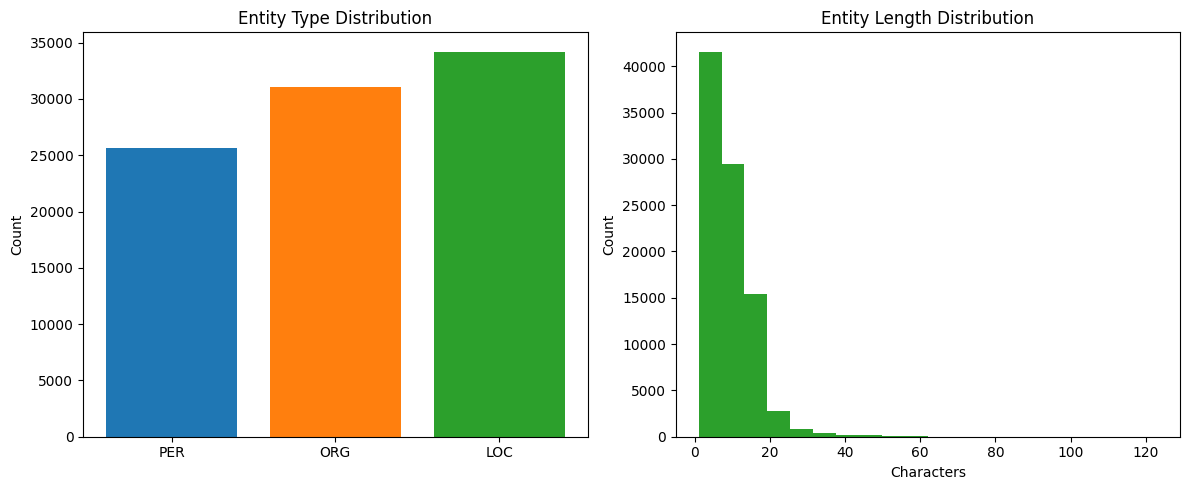

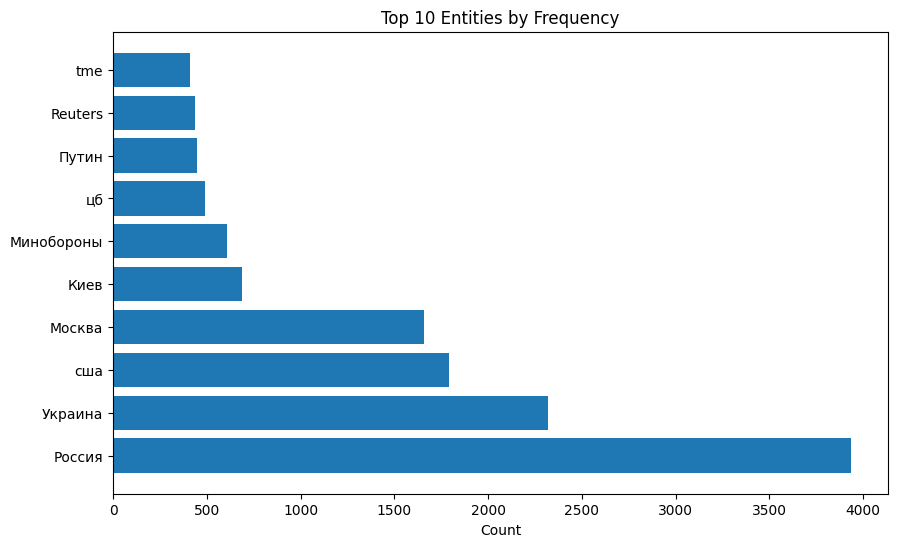


=== ENHANCED EVALUATION RESULTS ===

Entity Count: 91089 (after normalization)
Unique Entities: 26478 (29.1% uniqueness)
Documents Covered: 17626
Avg Entities/Doc: 5.2

Entity Type Distribution:
- PER: 25663 entities
- ORG: 31061 entities
- LOC: 34208 entities
- OTHER: 157 entities

Quality Metrics:
- Type Consistency: 96.7%
- Proper Casing: 65.8% (excl. person names)
- Numeric Entities: 0.4%
- Length Quality: 0.65/1.0

Overall Quality Score: 0.73/1.00

Status: GOOD - Suitable for most applications

Sample Processed Entities:

1. АлексейКорнилов (PER)
   Source Document: aae11f1a...
   Date: 2025-03-31
   Time: 15:56:14+00:00
   Context: **Разворот в 2025 году: ждать или нет? ** Банк России...

2. втбмоиинвестиция (ORG)
   Source Document: aae11f1a...
   Date: 2025-03-31
   Time: 15:56:14+00:00
   Context: **Разворот в 2025 году: ждать или нет? ** Банк России...

3. СтаниславКлещев (PER)
   Source Document: aae11f1a...
   Date: 2025-03-31
   Time: 15:56:14+00:00
   Context: **Разворот

In [4]:
# Install required packages
!pip install pymorphy3 matplotlib

import csv
import matplotlib.pyplot as plt
from collections import defaultdict
import pymorphy3

class PurePythonNEREvaluator:
    def __init__(self, data):
        self.morph = pymorphy3.MorphAnalyzer()
        self.data = self._preprocess_data(data)
        self.results = {}

    def _lemmatize_russian(self, text, is_person=False):
        """Convert Russian word to its nominative form with case preservation"""
        if is_person:
            return str(text)  # Don't lemmatize person names

        parsed = self.morph.parse(str(text))[0]
        lemma = parsed.normal_form if parsed else str(text)

        # Preserve original capitalization
        if text.istitle():
            return lemma.title()
        return lemma

    def _preprocess_data(self, data):
        """Filter unwanted entities, normalize text, and split time column"""
        filtered_data = []
        unwanted_entities = {'telegram', 'rbc', 'РБК'}

        for entity in data:
            # Skip unwanted entities (case insensitive)
            if str(entity['entity_text']).lower() in {e.lower() for e in unwanted_entities}:
                continue

            processed = entity.copy()
            is_person = processed.get('entity_type') == 'PER'

            # Normalize entity text
            processed['entity_text'] = self._lemmatize_russian(
                processed['entity_text'],
                is_person=is_person
            )

            # Split time into date and time components
            if 'time' in processed:
                time_str = str(processed['time'])
                if ' ' in time_str:
                    date_part, time_part = time_str.split(' ', 1)
                    processed['date'] = date_part
                    processed['time'] = time_part
                else:
                    processed['date'] = time_str
                    processed['time'] = ''

            filtered_data.append(processed)

        return filtered_data

    def save_processed_data(self, filename='processed_entities.csv'):
        """Save the processed data to a CSV file"""
        if not self.data:
            print("No data to save")
            return False

        try:
            # Determine all possible fieldnames
            fieldnames = set()
            for entity in self.data:
                fieldnames.update(entity.keys())
            fieldnames = sorted(fieldnames)

            with open(filename, mode='w', encoding='utf-8', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(self.data)

            print(f"\nSuccessfully saved processed data to {filename}")
            return True
        except Exception as e:
            print(f"\nError saving processed data: {str(e)}")
            return False

    def calculate_stats(self):
        """Calculate enhanced statistics"""
        stats = {
            'total_entities': len(self.data),
            'unique_entities': len({e['entity_text'] for e in self.data}),
            'type_counts': self._count_entity_types(),
            'avg_length': sum(len(str(e['entity_text'])) for e in self.data) / len(self.data) if self.data else 0,
            'docs_covered': len({e['sha'] for e in self.data}) if self.data and 'sha' in self.data[0] else 1,
            'avg_entities_per_doc': len(self.data) / len({e['sha'] for e in self.data}) if self.data and 'sha' in self.data[0] else 0
        }
        self.results['stats'] = stats
        return stats

    def _count_entity_types(self):
        """Count entity types with validation"""
        counts = defaultdict(int)
        valid_types = {'PER', 'ORG', 'LOC'}  # Only count these standard types

        for entity in self.data:
            entity_type = entity['entity_type']
            if entity_type in valid_types:
                counts[entity_type] += 1
            else:
                counts['OTHER'] = counts.get('OTHER', 0) + 1
        return dict(counts)

    def analyze_quality(self):
        """Enhanced quality analysis"""
        quality = {
            'type_consistency': self._type_consistency_score(),
            'numeric_entities': self._numeric_ratio(),
            'proper_casing': self._proper_casing_ratio(),
            'length_quality': min(1.0, self.results['stats']['avg_length'] / 15)  # Normalized length factor
        }
        self.results['quality'] = quality
        return quality

    def _type_consistency_score(self):
        """Enhanced type conflict detection"""
        type_map = {}
        conflicts = 0
        total_comparable = 0

        for entity in self.data:
            text = str(entity['entity_text'])
            etype = entity['entity_type']

            if text in type_map:
                total_comparable += 1
                if type_map[text] != etype:
                    conflicts += 1
            else:
                type_map[text] = etype

        return 1 - (conflicts / total_comparable) if total_comparable > 0 else 1.0

    def _numeric_ratio(self):
        """Calculate ratio of numeric entities"""
        if not self.data:
            return 0

        count = 0
        for entity in self.data:
            if any(c.isdigit() for c in str(entity['entity_text'])):
                count += 1
        return count / len(self.data)

    def _proper_casing_ratio(self):
        """Calculate ratio of properly cased entities"""
        if not self.data:
            return 0

        count = 0
        for entity in self.data:
            text = str(entity['entity_text'])
            # Only check casing for non-person entities
            if entity['entity_type'] != 'PER' and text != text.lower() and text != text.upper():
                count += 1
        return count / len([e for e in self.data if e['entity_type'] != 'PER']) if any(e['entity_type'] != 'PER' for e in self.data) else 1.0

    def visualize(self):
        """Enhanced visualization"""
        if not self.data:
            print("No data to visualize")
            return

        stats = self.results['stats']

        # Entity type distribution
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        type_counts = {k: v for k, v in stats['type_counts'].items() if k in {'PER', 'ORG', 'LOC'}}
        plt.bar(type_counts.keys(), type_counts.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.title('Entity Type Distribution')
        plt.ylabel('Count')

        # Entity length distribution
        plt.subplot(1, 2, 2)
        lengths = [len(str(e['entity_text'])) for e in self.data]
        plt.hist(lengths, bins=20, color='#2ca02c')
        plt.title('Entity Length Distribution')
        plt.xlabel('Characters')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

        # Top entities
        top_entities = self._get_top_entities(10)
        plt.figure(figsize=(10, 6))
        plt.barh(list(top_entities.keys()), list(top_entities.values()), color='#1f77b4')
        plt.title('Top 10 Entities by Frequency')
        plt.xlabel('Count')
        plt.show()

    def _get_top_entities(self, n=5):
        """Get top n entities with frequency"""
        counts = defaultdict(int)
        for entity in self.data:
            counts[str(entity['entity_text'])] += 1
        return dict(sorted(counts.items(), key=lambda x: -x[1])[:n])

    def calculate_score(self):
        """Optimized scoring for normalized data"""
        stats = self.results.get('stats', {})
        quality = self.results.get('quality', {})

        if not stats or not quality:
            return 0.0

        # Adjusted weights for normalized data
        score = (
            0.5 * quality['type_consistency'] +
            0.3 * (stats['unique_entities'] / stats['total_entities']) +
            0.1 * (1 - quality['numeric_entities']) +
            0.1 * quality['length_quality']
        )

        self.results['score'] = max(0.0, min(1.0, round(score, 2)))
        return self.results['score']

    def evaluate(self, save_output=True):
        """Complete evaluation with enhanced reporting"""
        print("Starting Enhanced NER Evaluation...\n")

        try:
            self.calculate_stats()
            self.analyze_quality()
            self.visualize()
            score = self.calculate_score()

            stats = self.results['stats']
            quality = self.results['quality']

            print("\n=== ENHANCED EVALUATION RESULTS ===")
            print(f"\nEntity Count: {stats['total_entities']} (after normalization)")
            print(f"Unique Entities: {stats['unique_entities']} ({stats['unique_entities']/stats['total_entities']:.1%} uniqueness)")
            print(f"Documents Covered: {stats['docs_covered']}")
            print(f"Avg Entities/Doc: {stats['avg_entities_per_doc']:.1f}")

            print("\nEntity Type Distribution:")
            for typ, count in stats['type_counts'].items():
                print(f"- {typ}: {count} entities")

            print("\nQuality Metrics:")
            print(f"- Type Consistency: {quality['type_consistency']:.1%}")
            print(f"- Proper Casing: {quality['proper_casing']:.1%} (excl. person names)")
            print(f"- Numeric Entities: {quality['numeric_entities']:.1%}")
            print(f"- Length Quality: {quality['length_quality']:.2f}/1.0")

            print(f"\nOverall Quality Score: {score:.2f}/1.00")

            if score >= 0.75:
                print("\nStatus: EXCELLENT - High quality normalized data")
            elif score >= 0.6:
                print("\nStatus: GOOD - Suitable for most applications")
            elif score >= 0.5:
                print("\nStatus: FAIR - Needs some improvement")
            else:
                print("\nStatus: NEEDS WORK - Significant issues detected")

            print("\nSample Processed Entities:")
            sample = [e for e in self.data if e['entity_type'] in {'PER', 'ORG', 'LOC'}][:3]
            for i, entity in enumerate(sample):
                print(f"\n{i+1}. {entity['entity_text']} ({entity['entity_type']})")
                print(f"   Source Document: {entity.get('sha', 'N/A')[:8]}...")
                print(f"   Date: {entity.get('date', 'N/A')}")
                print(f"   Time: {entity.get('time', 'N/A')}")
                if 'news_content' in entity:
                    preview = ' '.join(entity['news_content'].split()[:10]) + '...'
                    print(f"   Context: {preview}")

            # Save processed data if requested
            if save_output:
                self.save_processed_data()

            return self.results

        except Exception as e:
            print(f"\nEvaluation error: {str(e)}")
            return None

def try_load_csv(filename):
    """Robust CSV loader with encoding detection"""
    encodings = ['utf-8', 'utf-16', 'windows-1251', 'cp1251', 'iso-8859-1']

    for encoding in encodings:
        try:
            with open(filename, mode='r', encoding=encoding) as f:
                return list(csv.DictReader(f))
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"Error with {encoding}: {str(e)}")
            continue

    print("Failed to read file with all attempted encodings")
    return None

# Load data with fallback to sample data
print("Loading data...")
data = try_load_csv('entities_3column.csv') or [
    {
        'news_content': "Разворот в 2025 году: ждать или нет? Банк России на последнем заседании...",
        'entity_text': "Алексей Корнилов",
        'entity_type': "PER",
        'time': "2025-03-31 15:56:14+00:00",
        'sha': "aae11f1ab78dc3dd5d32a4bc0661f34e9f69088aa7c1257db2fac213374f8502"
    },
    {
        'news_content': "ВТБ инвестиции объявили о новых тарифах",
        'entity_text': "ВТБ",
        'entity_type': "ORG",
        'time': "2025-03-31 16:00:00+00:00",
        'sha': "bbe11f1ab78dc3dd5d32a4bc0661f34e9f69088aa7c1257db2fac213374f8502"
    },
    {
        'news_content': "Экономика России показывает рост",
        'entity_text': "России",
        'entity_type': "LOC",
        'time': "2025-03-31 17:00:00+00:00",
        'sha': "cce11f1ab78dc3dd5d32a4bc0661f34e9f69088aa7c1257db2fac213374f8502"
    }
]

# Run evaluation and save results
print("\nRunning evaluation...")
evaluator = PurePythonNEREvaluator(data)
results = evaluator.evaluate(save_output=True)  # Set save_output=False to skip saving